In [337]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization, Normalization
import keras_tuner as kt
from keras_tuner import Objective
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor 
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


### Preprocess-Reduccion de dimensionalidad (PCA)

In [306]:
def reduc_pca(df):
    df_copy = df.copy()
    
    # Selecciona las características afectadas por multicolinealidad
    features_to_pca = df_copy[['allelectrons_Average', 'density_Average', 'R_vdw_element_Average', 'atomicweight_Average','zaratio_Average','R_cov_element_Average']]
    
    # Estandariza las características antes de aplicar PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_to_pca)
    
    # Aplica PCA
    pca = PCA(n_components=0.95) 
    components = pca.fit_transform(features_scaled)
    print(f"Número de componentes seleccionados: {pca.n_components_}")
    
    # Crea nombres para los nuevos componentes
    new_component_names = [f'PCA_Component_{i+1}' for i in range(components.shape[1])]
    
    # Añade los nuevos componentes al DataFrame
    df_copy[new_component_names] = components
    
    # Elimina las características originales afectadas por multicolinealidad
    #df_copy.drop(['allelectrons_Average', 'density_Average', 'R_vdw_element_Average', 'atomicweight_Average', 'zaratio_Average','R_cov_element_Average'], axis=1, inplace=True)
    
    # movemos Hardness al final del df
    if 'Hardness' in df_copy.columns:
            if df_copy['Hardness'].isnull().all():
                # La columna 'Hardness' existe y todos sus valores son nulos
                print("Todos los valores de 'Hardness' son nulos.")
            else:
                # La columna 'Hardness' tiene al menos un valor no nulo
                Hardness = df_copy.pop('Hardness')
                df_copy['Hardness'] = Hardness
    else:
        # La columna 'Hardness' no existe en el DataFrame
        print("La columna 'Hardness' no existe en el DataFrame.")
    
    return df_copy
    

In [4]:
df = reduc_pca(df)

Número de componentes seleccionados: 4


In [5]:
df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,Hardness
id,,,,,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,-1.111271,-0.149722,-0.401556,-0.026638,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,-1.224308,0.074271,-0.379823,0.083014,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,-0.321924,0.029238,-0.251617,0.128897,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,-1.146938,0.094446,-0.448528,0.047033,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,-0.746181,0.087805,-0.131870,-0.272518,6.0


### Eliminar valores atipicos (solo en dataset de entrenamiento)

In [6]:
# Eliminar atipicos
def outliers_iqr(df, column_names, lower_limit=0.01, upper_limit=0.99):
    copy_df = df.copy()
    
    for column_name in column_names:
        # Calcula percentiles para limitar los valores atípicos
        lower_percentile = copy_df[column_name].quantile(lower_limit)
        upper_percentile = copy_df[column_name].quantile(upper_limit)

        # Identifica y elimina las filas que contienen valores atípicos
        copy_df = copy_df[~((copy_df[column_name] < lower_percentile) | (copy_df[column_name] > upper_percentile))]

    return copy_df
    

In [7]:
df = outliers_iqr(df, ['allelectrons_Total','density_Total','ionenergy_Average','el_neg_chi_Average'], 
                            lower_limit=0.01, upper_limit=0.99)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
 11  PCA_Component_1        9695 non-null   float64
 12  PCA_Component_2        9695 non-null   float64
 13  PCA_Component_3        9695 non-null   float64
 14  PCA_Component_4        9695 non-null   float64
 15  Hardness

In [11]:
# Guardar csv
df.to_csv('clustering_kmeans.csv', index=False)

In [386]:
# Separamos en X e y
X = df.iloc[:, :-1]
y = df.iloc[:, 15]

In [373]:
y

id
1        6.5
2        2.5
3        6.0
4        6.0
5        6.0
        ... 
10401    6.8
10402    4.0
10404    1.8
10405    6.0
10406    6.5
Name: Hardness, Length: 9695, dtype: float64

In [374]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
 11  PCA_Component_1        9695 non-null   float64
 12  PCA_Component_2        9695 non-null   float64
 13  PCA_Component_3        9695 non-null   float64
 14  PCA_Component_4        9695 non-null   float64
dtypes: float

### Algoritmo de agrupacion -  nuevas caracteristicas y patrones

In [355]:
# clase personalizada, prediccion de clusters.
class ClusteringClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        # Preservar nombre de columnas
        column_names = X_copy.columns.tolist()
        # Escalado
        scaler = StandardScaler()
        X_copy = scaler.fit_transform(X_copy)
        
        # kmeans
        kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=42)
        y_kmeans = kmeans.fit_predict(X_copy)
        
        # Desescalado de X
        X_copy = scaler.inverse_transform(X_copy)
        
        # transformar a series de pandas(dataframe)
        X_copy = pd.DataFrame(X_copy, columns= column_names)
        
        # Unir nueva columna a X
        X_copy['cluster'] = y_kmeans.tolist()
        
        return X_copy

In [13]:
clustering_class = ClusteringClass()

In [375]:
X = clustering_class.transform(X)

In [356]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
 11  PCA_Component_1        9695 non-null   float64
 12  PCA_Component_2        9695 non-null   float64
 13  PCA_Component_3        9695 non-null   float64
 14  PCA_Component_4        9695 non-null   float64
dtypes: float

### Transformaciones matematicas

In [380]:
# clase personalizada, transformaciones de variables.
class MathClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        #Proporcion electrones por densidad
        X_copy['electronic_density'] = X_copy['allelectrons_Total'] / (X_copy['density_Total'].replace(0, np.nan))
        X_copy['electronic_density'] = X_copy['electronic_density'].apply(lambda x: max(0, x))
        #Valor medio electrones y energia de ionizacion
        X_copy['v_mean_elecIo'] = X_copy['val_e_Average'] / (X_copy['ionenergy_Average'].replace(0, np.nan))
        X_copy['v_mean_elecIo'] = X_copy['v_mean_elecIo'].apply(lambda x: max(0, x))
        #Producto de la Densidad y la Energía de Ionización
        X_copy['pr_densIo'] = X_copy['density_Total']*X_copy['ionenergy_Average']
        
        # haciendo pruebas elimanos las tres ultimas, generan ruido y empeoran los resultados
        X_copy['log_density'] = X_copy['density_Total'].apply(lambda x: np.log(x) if x > 0 else 0)
        
        X_copy = X_copy.drop(['PCA_Component_4', 'electronic_density', 'PCA_Component_2'], axis = 1)
        
        return X_copy

In [381]:
math_class = MathClass()

In [382]:
X = math_class.transform(X)

In [383]:
X.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,PCA_Component_1,PCA_Component_3,cluster,v_mean_elecIo,pr_densIo,log_density
0,100.0,7.558488,10.000000,4.800000,20.298893,12.04083,2.755000,1.631000,0.910000,0.492719,0.71760,-1.224308,-0.379823,6,0.398644,91.010469,2.022671
1,76.0,8.885992,15.600000,5.600000,33.739258,12.08630,2.828000,1.788000,0.864000,0.481478,1.50633,-0.321924,-0.251617,6,0.463335,107.398765,2.184476
2,100.0,8.795296,10.000000,4.800000,20.213349,10.94850,2.648000,1.626000,0.936000,0.489272,0.78937,-1.146938,-0.448528,6,0.438416,96.295298,2.174217
3,116.0,9.577996,11.600000,4.800000,24.988133,11.82448,2.766000,1.682000,0.896000,0.492736,1.86481,-0.746181,-0.131870,6,0.405938,113.254822,2.259468
4,131.0,24.529328,21.833333,4.666667,50.131500,11.94820,2.858333,1.758333,0.896667,0.466388,2.94712,0.650988,0.228052,0,0.390575,293.081317,3.199869


In [384]:
# Importancia segun p-values de las caracteristicas nuevas
f_values, p_values = f_classif(X, y)
anova_results_df = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})
anova_results_df = anova_results_df.sort_values(by='p-value', ascending=True)
print(anova_results_df)

                  Feature    F-value        p-value
2    allelectrons_Average  55.727002   0.000000e+00
11        PCA_Component_1  43.979989   0.000000e+00
4    atomicweight_Average  55.830323   0.000000e+00
10        density_Average  42.076511   0.000000e+00
6      el_neg_chi_Average  32.902327  1.417517e-275
12        PCA_Component_3  29.591847  1.255243e-246
8   R_cov_element_Average  23.058958  1.283252e-188
5       ionenergy_Average  17.936900  1.922169e-142
7   R_vdw_element_Average  15.691345  4.496945e-122
16            log_density  12.393553   3.852020e-92
1           density_Total   9.748841   2.815661e-68
3           val_e_Average   9.670318   1.424393e-67
14          v_mean_elecIo   9.282423   4.227465e-64
15              pr_densIo   6.771135   6.082527e-42
9         zaratio_Average   6.547425   5.231398e-40
0      allelectrons_Total   5.824490   8.019356e-34
13                cluster   4.619206   8.196578e-24


### Prediccion con Random Forest, evaluacion y rectificado

In [190]:
# prediccion prueba con random forest
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [192]:
regressor = RandomForestRegressor(random_state=42, oob_score=True)
model = regressor.fit(X_train, y_train)

In [193]:
oob_score = model.oob_score_
print("R^2 Score:", oob_score)

R^2 Score: 0.44669454005980136


In [194]:
# importancia de caracteristicas segun randomforest
for score, name in zip(regressor.feature_importances_, y_train):
    print(round(score, 2), name)

0.05 5.0
0.02 6.0
0.05 3.8
0.05 5.5
0.05 3.5
0.12 6.8
0.05 5.5
0.04 2.5
0.04 5.3
0.06 5.8
0.05 2.5
0.24 5.5
0.06 3.5
0.01 7.5
0.05 2.5
0.03 5.0
0.02 6.0


In [195]:
y_pred = model.predict(X_test)

In [196]:
#MSE y RMSE
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse=math.sqrt(mse)
print(rmse)
medae = median_absolute_error(y_test, y_pred)
print('MedAE:', medae)

1.764683488251676
1.328413899449895
MedAE: 0.7299999999999969


Hemos obtenido una mejora con respecto a la baseline inicial.
Probaremos con otro modelo mas complejo.

*la evaluacion de los modelos en la competicion se realiza con la metrica medae (error absoluto mediano)*

---------------------------------------

Baseline -> MedAE: 0.97

RandomForest -> MedAE: 0.72

### Automatizacion de preprocesado con pipeline

In [387]:
pipeline = make_pipeline(clustering_class, math_class)

X_processed = pipeline.fit_transform(X)
X_processed

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,PCA_Component_1,PCA_Component_3,cluster,v_mean_elecIo,pr_densIo,log_density
0,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,-1.224308,-0.379823,6,0.398644,91.010469,2.022671
1,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,-0.321924,-0.251617,6,0.463335,107.398765,2.184476
2,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,-1.146938,-0.448528,6,0.438416,96.295298,2.174217
3,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,-0.746181,-0.131870,6,0.405938,113.254822,2.259468
4,131.0,24.529328,21.833333,4.666667,50.131500,11.948200,2.858333,1.758333,0.896667,0.466388,2.94712,0.650988,0.228052,0,0.390575,293.081317,3.199869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9690,104.0,11.202328,17.333333,4.666667,39.987667,11.408267,2.736667,1.796667,0.966667,0.485033,1.95480,0.223466,-0.265490,4,0.409060,127.799145,2.416122
9691,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,-0.834660,0.028256,6,0.353031,85.640995,2.022671
9692,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,0.766877,0.137073,0,0.545944,311.497356,3.431403
9693,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,-0.546023,-0.706767,4,0.413344,17.535228,0.440292


### Prediccion con Redes Neuronales

In [388]:
# prediccion xgboost con X_train.

# prediccion con xgboost antes de utilizar redes neuronales, para añadir caracteristica nueva 
# Divide tus datos en conjuntos de entrenamiento y val
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
xgb_rr = XGBRegressor(objective ='reg:squarederror', 
                      n_estimators = 10, seed = 123)

xgb_rr.fit(X_train, y_train) 
xgb_rr_pred = xgb_rr.predict(X_test)
xgb_rr_mae = median_absolute_error(y_test, xgb_rr_pred)

print(f'Mean Absolute Error for XGBRegressor  with reg:squarederror is:{xgb_rr_mae: .6f}')
    
# Añadir caracteristicas a X_processed
X_processed['Hardness_xgb'] = xgb_rr.predict(X_processed)

Mean Absolute Error for XGBRegressor  with reg:squarederror is: 0.703957


### Keras Tuner, busqueda aleatoria de hiperparametros

In [247]:
# prediccion prueba con redes neuronales
# Divide tus datos en conjuntos de entrenamiento y prueba sobrescribiendo el anterior
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [253]:
def model (hp):
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=10, default=2)
    n_neurons = hp.Int('n_neurons', min_value=1, max_value=10)
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=['adam'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(Normalization())
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
        model.add(BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
    
    return model

In [254]:
random_search_tuner = kt.RandomSearch(
    model, Objective("val_root_mean_squared_error", direction="min"), max_trials=100, overwrite=True, seed=42
)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
random_search_tuner.search(X_train, y_train,batch_size=35, epochs=100, callbacks=[early_stop], validation_data=(X_test, y_test))

Trial 100 Complete [00h 00m 19s]
val_root_mean_squared_error: 1.31023371219635

Best val_root_mean_squared_error So Far: 1.3006783723831177
Total elapsed time: 00h 55m 05s


In [255]:
# cargamos el mejor modelo hasta la fecha
top3_models = random_search_tuner.get_best_models(num_models=3)
best_models = top3_models[0]

### Ajuste manual de hiperparametros

In [288]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_dim=18)

modelo = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear'),
])

optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelo.compile(optimizer=optimizador, loss='mse', metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)


In [289]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [290]:
# Ajustar y entrenar el modelo de red neuronal
history=modelo.fit(X_train, y_train, batch_size=10, epochs=100,callbacks=[early_stop], validation_data=(X_test, y_test))

Epoch 1/100
776/776 [==============================] - 6s 5ms/step - loss: 20.2492 - root_mean_squared_error: 4.4999 - val_loss: 15.0633 - val_root_mean_squared_error: 3.8811
Epoch 2/100
776/776 [==============================] - 3s 4ms/step - loss: 10.6802 - root_mean_squared_error: 3.2681 - val_loss: 6.1040 - val_root_mean_squared_error: 2.4706
Epoch 3/100
776/776 [==============================] - 3s 4ms/step - loss: 3.9187 - root_mean_squared_error: 1.9796 - val_loss: 2.6583 - val_root_mean_squared_error: 1.6304
Epoch 4/100
776/776 [==============================] - 3s 4ms/step - loss: 2.1755 - root_mean_squared_error: 1.4750 - val_loss: 2.2831 - val_root_mean_squared_error: 1.5110
Epoch 5/100
776/776 [==============================] - 3s 4ms/step - loss: 1.9599 - root_mean_squared_error: 1.4000 - val_loss: 2.1044 - val_root_mean_squared_error: 1.4507
Epoch 6/100
776/776 [==============================] - 3s 4ms/step - loss: 1.8167 - root_mean_squared_error: 1.3479 - val_loss: 1.94

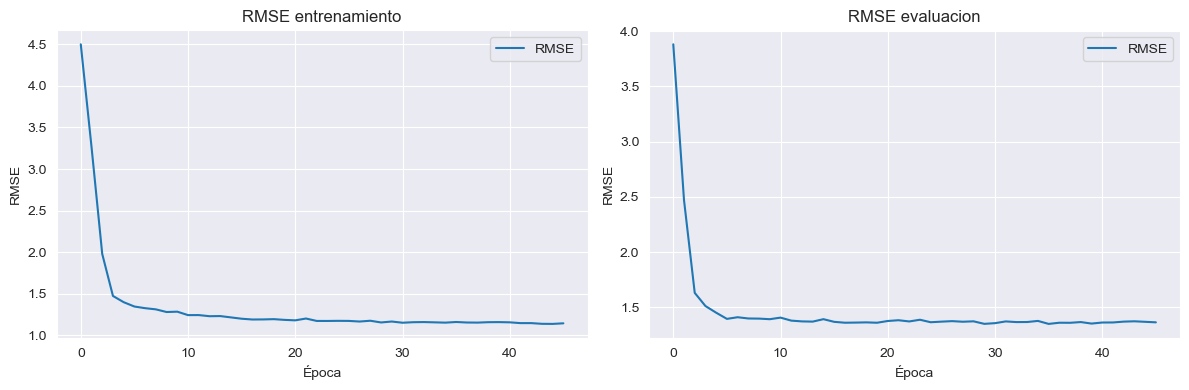

In [291]:
# Obtener las métricas de entrenamiento
loss = history.history['root_mean_squared_error']
mse = history.history['val_root_mean_squared_error']

# Graficar la pérdida y la métrica MSE
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='RMSE')
plt.title('RMSE entrenamiento')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Gráfico de la métrica MSE
plt.subplot(1, 2, 2)
plt.plot(mse, label='RMSE')
plt.title('RMSE evaluacion')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [292]:
y_pred = best_models.predict(X_test)

61/61 [==============================] - 0s 1ms/step


In [293]:
medae = median_absolute_error(y_test, y_pred)
print('medae=',medae)

medae= 0.6817131042480469


Nos quedaremos con el modelo encontrado por keras-tuner, siendo mejor al modelo por busqueda manual

### Prediccion con el conjunto de prueba

In [389]:
df_prueba = pd.read_csv('test.csv')
df_prueba

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227


In [390]:
id_ = df_prueba['id']
df_prueba = df_prueba.drop('id', axis = 1)

In [391]:
# llamamos a las funciones y pipeline de preprocesamiento
df_prueba = reduc_pca(df_prueba)
X_prueba = pipeline.fit_transform(df_prueba)
X_prueba['Hardness_xgb'] = xgb_rr.predict(X_prueba)

Número de componentes seleccionados: 4
La columna 'Hardness' no existe en el DataFrame.


In [393]:
X_prueba.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
PCA_Component_1          0
PCA_Component_3          0
cluster                  0
v_mean_elecIo            0
pr_densIo                0
log_density              0
Hardness_xgb             0
dtype: int64

In [394]:
prediction = best_models.predict(X_prueba)

217/217 [==============================] - 0s 1ms/step


In [395]:
# Convertir cada matriz a un array NumPy unidimensional
prediction = np.squeeze(prediction)

In [396]:
df_submission = {'id': id_, 'Hardness': prediction}

In [397]:
data = pd.DataFrame(df_submission)
data

,id,Hardness
0,10407,1.712298
1,10408,2.951445
2,10409,5.606523
3,10410,3.778516
4,10411,5.215435
...,...,...
6934,17341,5.312084
6935,17342,4.264359
6936,17343,5.712439
6937,17344,3.934830


In [398]:
#guardar archivo csv
data.to_csv("Mosh_HardnessV1.csv", index=False)